In [4]:
import pandas as pd
import numpy as np

In [5]:
##The IMDB data has been uploaded to a public S3
movie = pd.read_csv("https://s3-us-west-2.amazonaws.com/imdbmo/imdb_master.csv", encoding="latin1", index_col = 0)

In [6]:
movie.tail(5)

,type,review,label,file
99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt
99999,train,"TCM came through by acquiring this wonderful, ...",unsup,9_0.txt


In [7]:
movie = movie.dropna()

In [8]:
## Remove the uncertain leabel "unsup"
movie2 = movie[movie.label != 'unsup']
movie2['pos'] = movie2['label'].map({'pos': 1, 'neg': 0})
movie2.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,type,review,label,file,pos
49995,train,"Seeing as the vote average was pretty low, and...",pos,9998_9.txt,1
49996,train,"The plot had some wretched, unbelievable twist...",pos,9999_8.txt,1
49997,train,I am amazed at how this movie(and most others ...,pos,999_10.txt,1
49998,train,A Christmas Together actually came before my t...,pos,99_8.txt,1
49999,train,Working-class romantic drama from director Mar...,pos,9_7.txt,1


In [9]:
import matplotlib.pyplot as plt

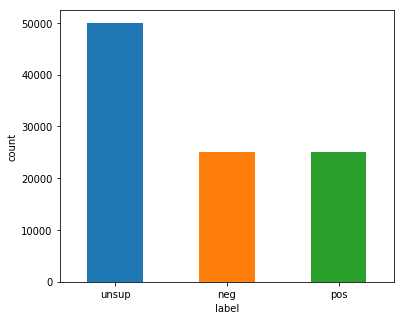

In [10]:
movie.label.value_counts().plot(kind="bar", rot=0, figsize=(6, 5))
plt.ylabel("count", fontsize=10)
plt.xlabel("label", fontsize=10)
plt.show()
##The histogram table of frequencies of labels

In [11]:
import nltk
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
##Define a function with NLTK to clean the text
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [13]:
movie2['formatted_reviews'] = movie2.review.apply(lambda x: clean_text(x))
print(movie2.formatted_reviews.head())

0    mr costner ha drag movie far longer necessary ...
1    example majority action film generic bore real...
2    first hate moronic rapper couldnt act gun pres...
3    even beatles could write song everyone like al...
4    brass picture movie fit word really somewhat b...
Name: formatted_reviews, dtype: object


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
movie2.formatted_reviews.apply(lambda x: len(x.split(" "))).mean()
##The average length of each review is:

127.99056

In [25]:
X_train = movie2[movie2.type == "train"].formatted_reviews
X_test = movie2[movie2.type == "test"].formatted_reviews
y_train = movie2[movie2.type == "train"].pos
y_test = movie2[movie2.type == "test"].pos

In [16]:
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [22]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
maxlen = 150
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [23]:
##Generate a long-short-term Neural Network
embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 5
model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 39s 2ms/step - loss: 0.4552 - acc: 0.7733 - val_loss: 0.5793 - val_acc: 0.7380
Epoch 2/5
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2305 - acc: 0.9115 - val_loss: 0.5738 - val_acc: 0.7450
Epoch 3/5
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1566 - acc: 0.9425 - val_loss: 0.6785 - val_acc: 0.7352
Epoch 4/5
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1113 - acc: 0.9635 - val_loss: 0.6951 - val_acc: 0.7680
Epoch 5/5
20000/20000 [==============================] - 35s 2ms/step - loss: 0.0874 - acc: 0.

In [26]:
#Predict using test data
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
X_tes = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_tes)
y_pred = (prediction > 0.5)
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.8346279128038087
Confusion matrix:


array([[11047,  2507],
       [ 1453,  9993]], dtype=int64)